In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from plotnine import ggplot, aes, geom_point, stat_function
from scipy.integrate import odeint


def lotka_volterra(X, t, a, b, c, d):
    '''Return growth rate of prey and predator populations.'''
    return np.array([a*X[0] - b*X[0]*X[1],
                     -c*X[1] + d*b*X[0]*X[1]])


def simulate_lotka_volterra(rng, a, b, c, d, size=None):
    return odeint(lotka_volterra, X0, time, rtol=0.01, args=(a, b, c, d))


def as_df(observed):
    return pd.DataFrame(np.column_stack((time, observed)),
                        columns=['time', 'prey', 'predator'])


def as_df_long(observed):
    return as_df(observed).melt('time')


def simulate_df_long(a, b):
    return as_df_long(simulate_lotka_volterra(None, a, b, c, d, size=None))


# Ground truth parameters to create data before adding any noise.
a = 1.0
b = 0.1
c = 1.5
d = 0.75

# Initial populations of prey and predator.
X0 = [10.0, 5.0]
# Time points.
n_steps = 100
time_end = 15
time = np.linspace(0, time_end, n_steps)

# Observations with noise.
observed = (simulate_lotka_volterra(None, a, b, c, d) +
            np.random.normal(size=(n_steps, 2)) +
            np.random.normal(size=(n_steps, 2)))

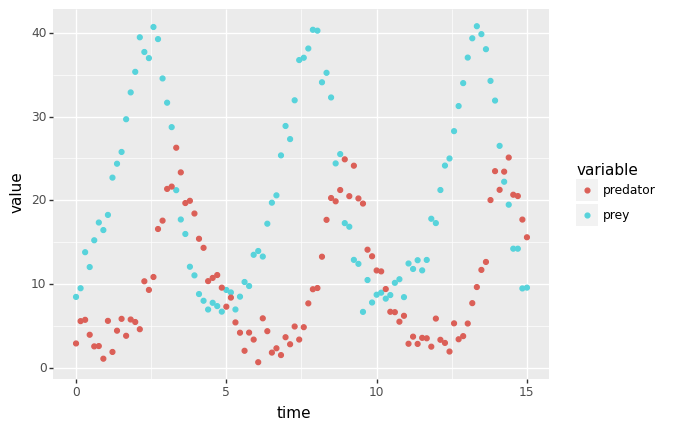

<ggplot: (338361834)>

In [2]:
(ggplot(as_df_long(observed),
        aes('time', 'value',
            group='variable',
            color='variable')) +
 geom_point())

In [3]:
# Create the model class instead of using a context manager ("with" statement)
# because the latter throws multiprocessing errors when running from a jupyter
# notebook.
class ModelLV(pm.Model):
    def __init__(self, name=''):
        super().__init__(name)
        a = pm.HalfNormal('a', 1.0)
        b = pm.HalfNormal('b', 1.0)
        c = pm.ConstantData('c', 1.5)
        d = pm.ConstantData('d', 0.75)
        # Simulator "distribution" for Approximate Bayesian Computing (ABC) with
        # Squential Monte Carlo (SMC) sampling for pm.sample_smc().
        # 
        # Instead of specifying a likelihood function, simulates from the model.
        sim = pm.Simulator('sim',
                           simulate_lotka_volterra,
                           params=(a, b, c, d),
                           epsilon=10,
                           observed=observed)


model = ModelLV()
print(__name__)

# Collect inference data.
idata_lv = pm.sample_smc(model=model, progressbar=False)

Initializing SMC sampler...


Sampling 8 chains in 8 jobs


__main__


Sampling: [a, b]
Sampling: [a, b]
Sampling: [a, b]
Sampling: [a, b]
Sampling: [a, b]
Sampling: [a, b]


Sampling: [a, b]
Sampling: [a, b]


/var/folders/sb/82r7skjn6yd9b8hsjz63npvr0000gs/T/ipykernel_16699/4125059093.py:12: RuntimeWarning: overflow encountered in multiply
/var/folders/sb/82r7skjn6yd9b8hsjz63npvr0000gs/T/ipykernel_16699/4125059093.py:12: RuntimeWarning: invalid value encountered in double_scalars


 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.1320074325123D+02   r2 =  0.1078944964913D-08


/usr/local/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


/usr/local/lib/python3.10/site-packages/arviz/data/base.py:221: UserWarning: More chains (8) than draws (7). Passed array should have shape (chains, draws, *shape)


In [4]:
idata_lv

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

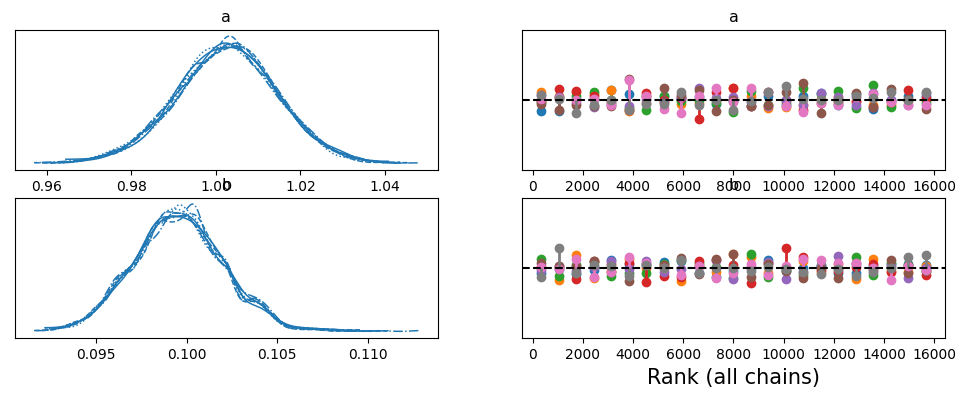

In [5]:
az.plot_trace(idata_lv, kind='rank_vlines')
plt.show()

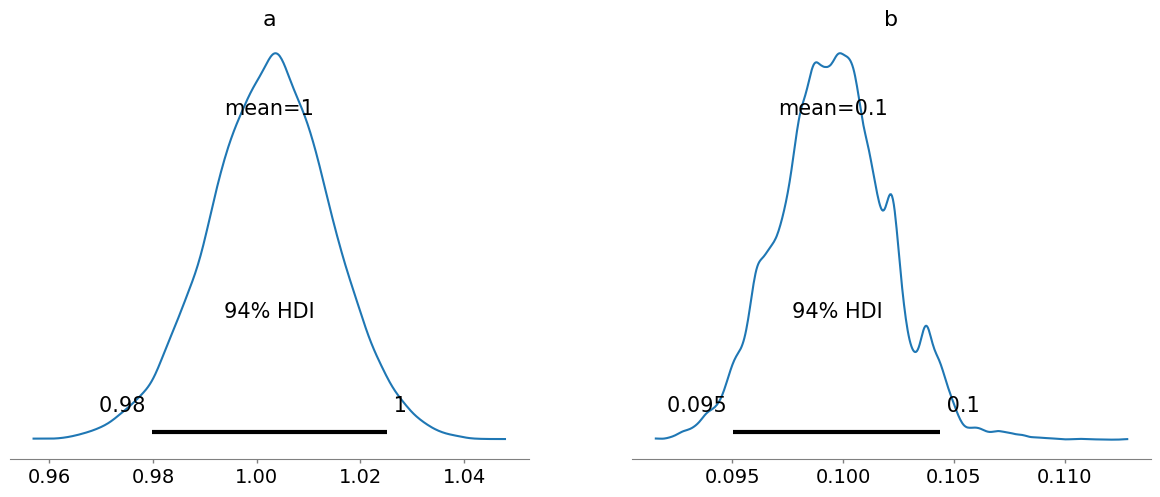

In [6]:
az.plot_posterior(idata_lv)
plt.show()

In [7]:
posterior = idata_lv.posterior.stack(samples=('draw', 'chain'))
